## Spaceship Titanic
### 배경
서기 2912년, 성간 여객선 '우주선 타이타닉(Spaceship Titanic)'이 시공간 이상(Spacetime Anomaly)과 충돌하는 사고가 발생합니다. 이 사고로 승객의 절반 정도가 다른 차원으로 전송되어 사라집니다.
### 임무
손상된 우주선 컴퓨터 시스템에서 복구된 승객 데이터(출발 행성, 나이, 객실 정보, 냉동 수면 여부 등)를 바탕으로, 각 승객이 다른 차원으로 전송되었는지 여부(True/False)를 맞혀야 합니다.


In [258]:
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [259]:
import warnings
warnings.filterwarnings("ignore")

import os
from os.path import join

import pandas as pd
import numpy as np

import missingno as msno

import matplotlib.pyplot as plt
import seaborn as sns

#### Data Loading
- Load the dataset from the given path
- 정답지(y)는 'Transported' 컬럼
- Train 데이터와 Test데이터를 합쳐서 data로 만들어서 처리.

In [260]:
data_dir = './spaceship-titanic/'

data = pd.read_csv(join(data_dir, 'train.csv'))
sub = pd.read_csv(join(data_dir, 'test.csv'))
print(f'train data dim : {data.shape}')
print(f'sub data dim : {sub.shape}')


train data dim : (8693, 14)
sub data dim : (4277, 13)


- train.csv와 test.csv를 합쳐서 한번에 데이터 확인 하는게 편함 
- 결과 값인 Transported를 y에  할당후 제거

In [261]:
# 결과값인 Transported 확인후 y에 할당후 제거 
display(set(data.columns) - set(sub.columns))
y = data['Transported']
del data['Transported']


# train.csv와 test.csv를 합쳐서 한번에 데이터 확인 하는게 편함
train_len = len(data)
data = pd.concat((data, sub), axis=0)

{'Transported'}

#### Data Analysis 
- `info`, `matrix`, 등을 활용해서 데이터의 결측치를 확인.
- `describe`와 `kdeplot`를 활용해서 데이터의 분포를 확인.

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines


,Age,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck
count,12700.000000,12707.000000,12681.000000,12664.000000,12686.000000,12702.000000
mean,28.771969,222.897852,451.961675,174.906033,308.476904,306.789482
std,14.387261,647.596664,1584.370747,590.558690,1130.279641,1180.097223
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,19.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,27.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,38.000000,49.000000,77.000000,29.000000,57.000000,42.000000
max,79.000000,14327.000000,29813.000000,23492.000000,22408.000000,24133.000000


<class 'pandas.DataFrame'>
Index: 12970 entries, 0 to 4276
Data columns (total 13 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   PassengerId   12970 non-null  str    
 1   HomePlanet    12682 non-null  str    
 2   CryoSleep     12660 non-null  object 
 3   Cabin         12671 non-null  str    
 4   Destination   12696 non-null  str    
 5   Age           12700 non-null  float64
 6   VIP           12674 non-null  object 
 7   RoomService   12707 non-null  float64
 8   FoodCourt     12681 non-null  float64
 9   ShoppingMall  12664 non-null  float64
 10  Spa           12686 non-null  float64
 11  VRDeck        12702 non-null  float64
 12  Name          12676 non-null  str    
dtypes: float64(6), object(2), str(5)
memory usage: 1.4+ MB


None

Number of null values:
PassengerId : 0
HomePlanet : 288
CryoSleep : 310
Cabin : 299
Destination : 274
Age : 270
VIP : 296
RoomService : 263
FoodCourt : 289
ShoppingMall : 306
Spa : 284
VRDeck : 268
Name : 294


<Axes: >

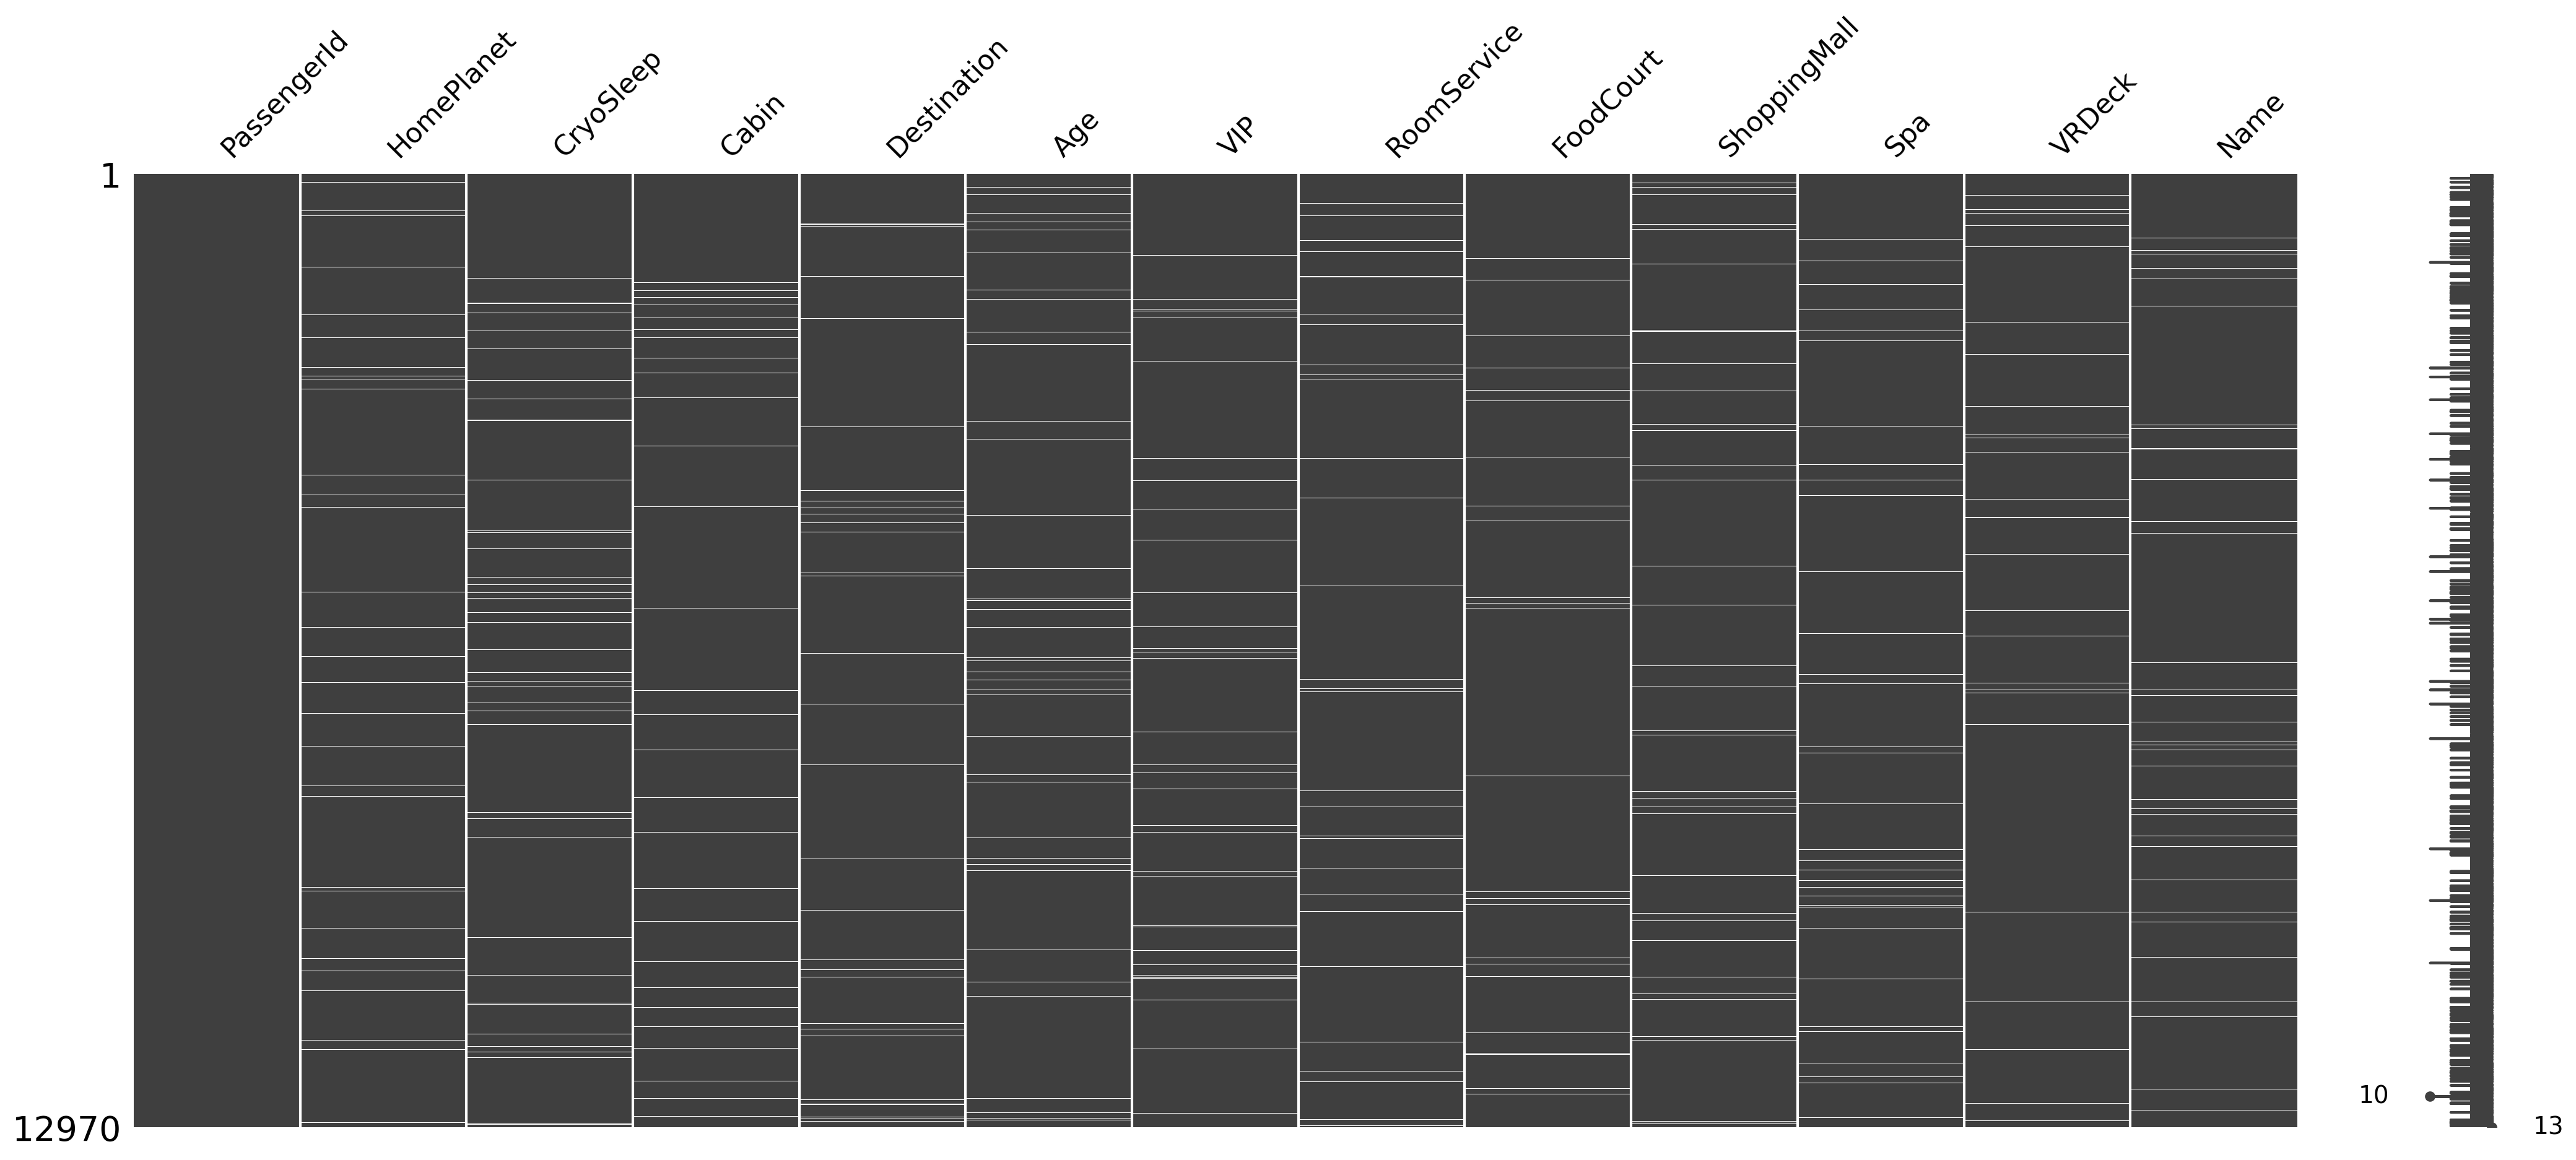

In [262]:
display(data.head())
display(data.describe())
display(data.info())

print("Number of null values:")
for c in data.columns:
    print('{} : {}'.format(c, len(data.loc[pd.isnull(data[c]), c].values)))

msno.matrix(data)

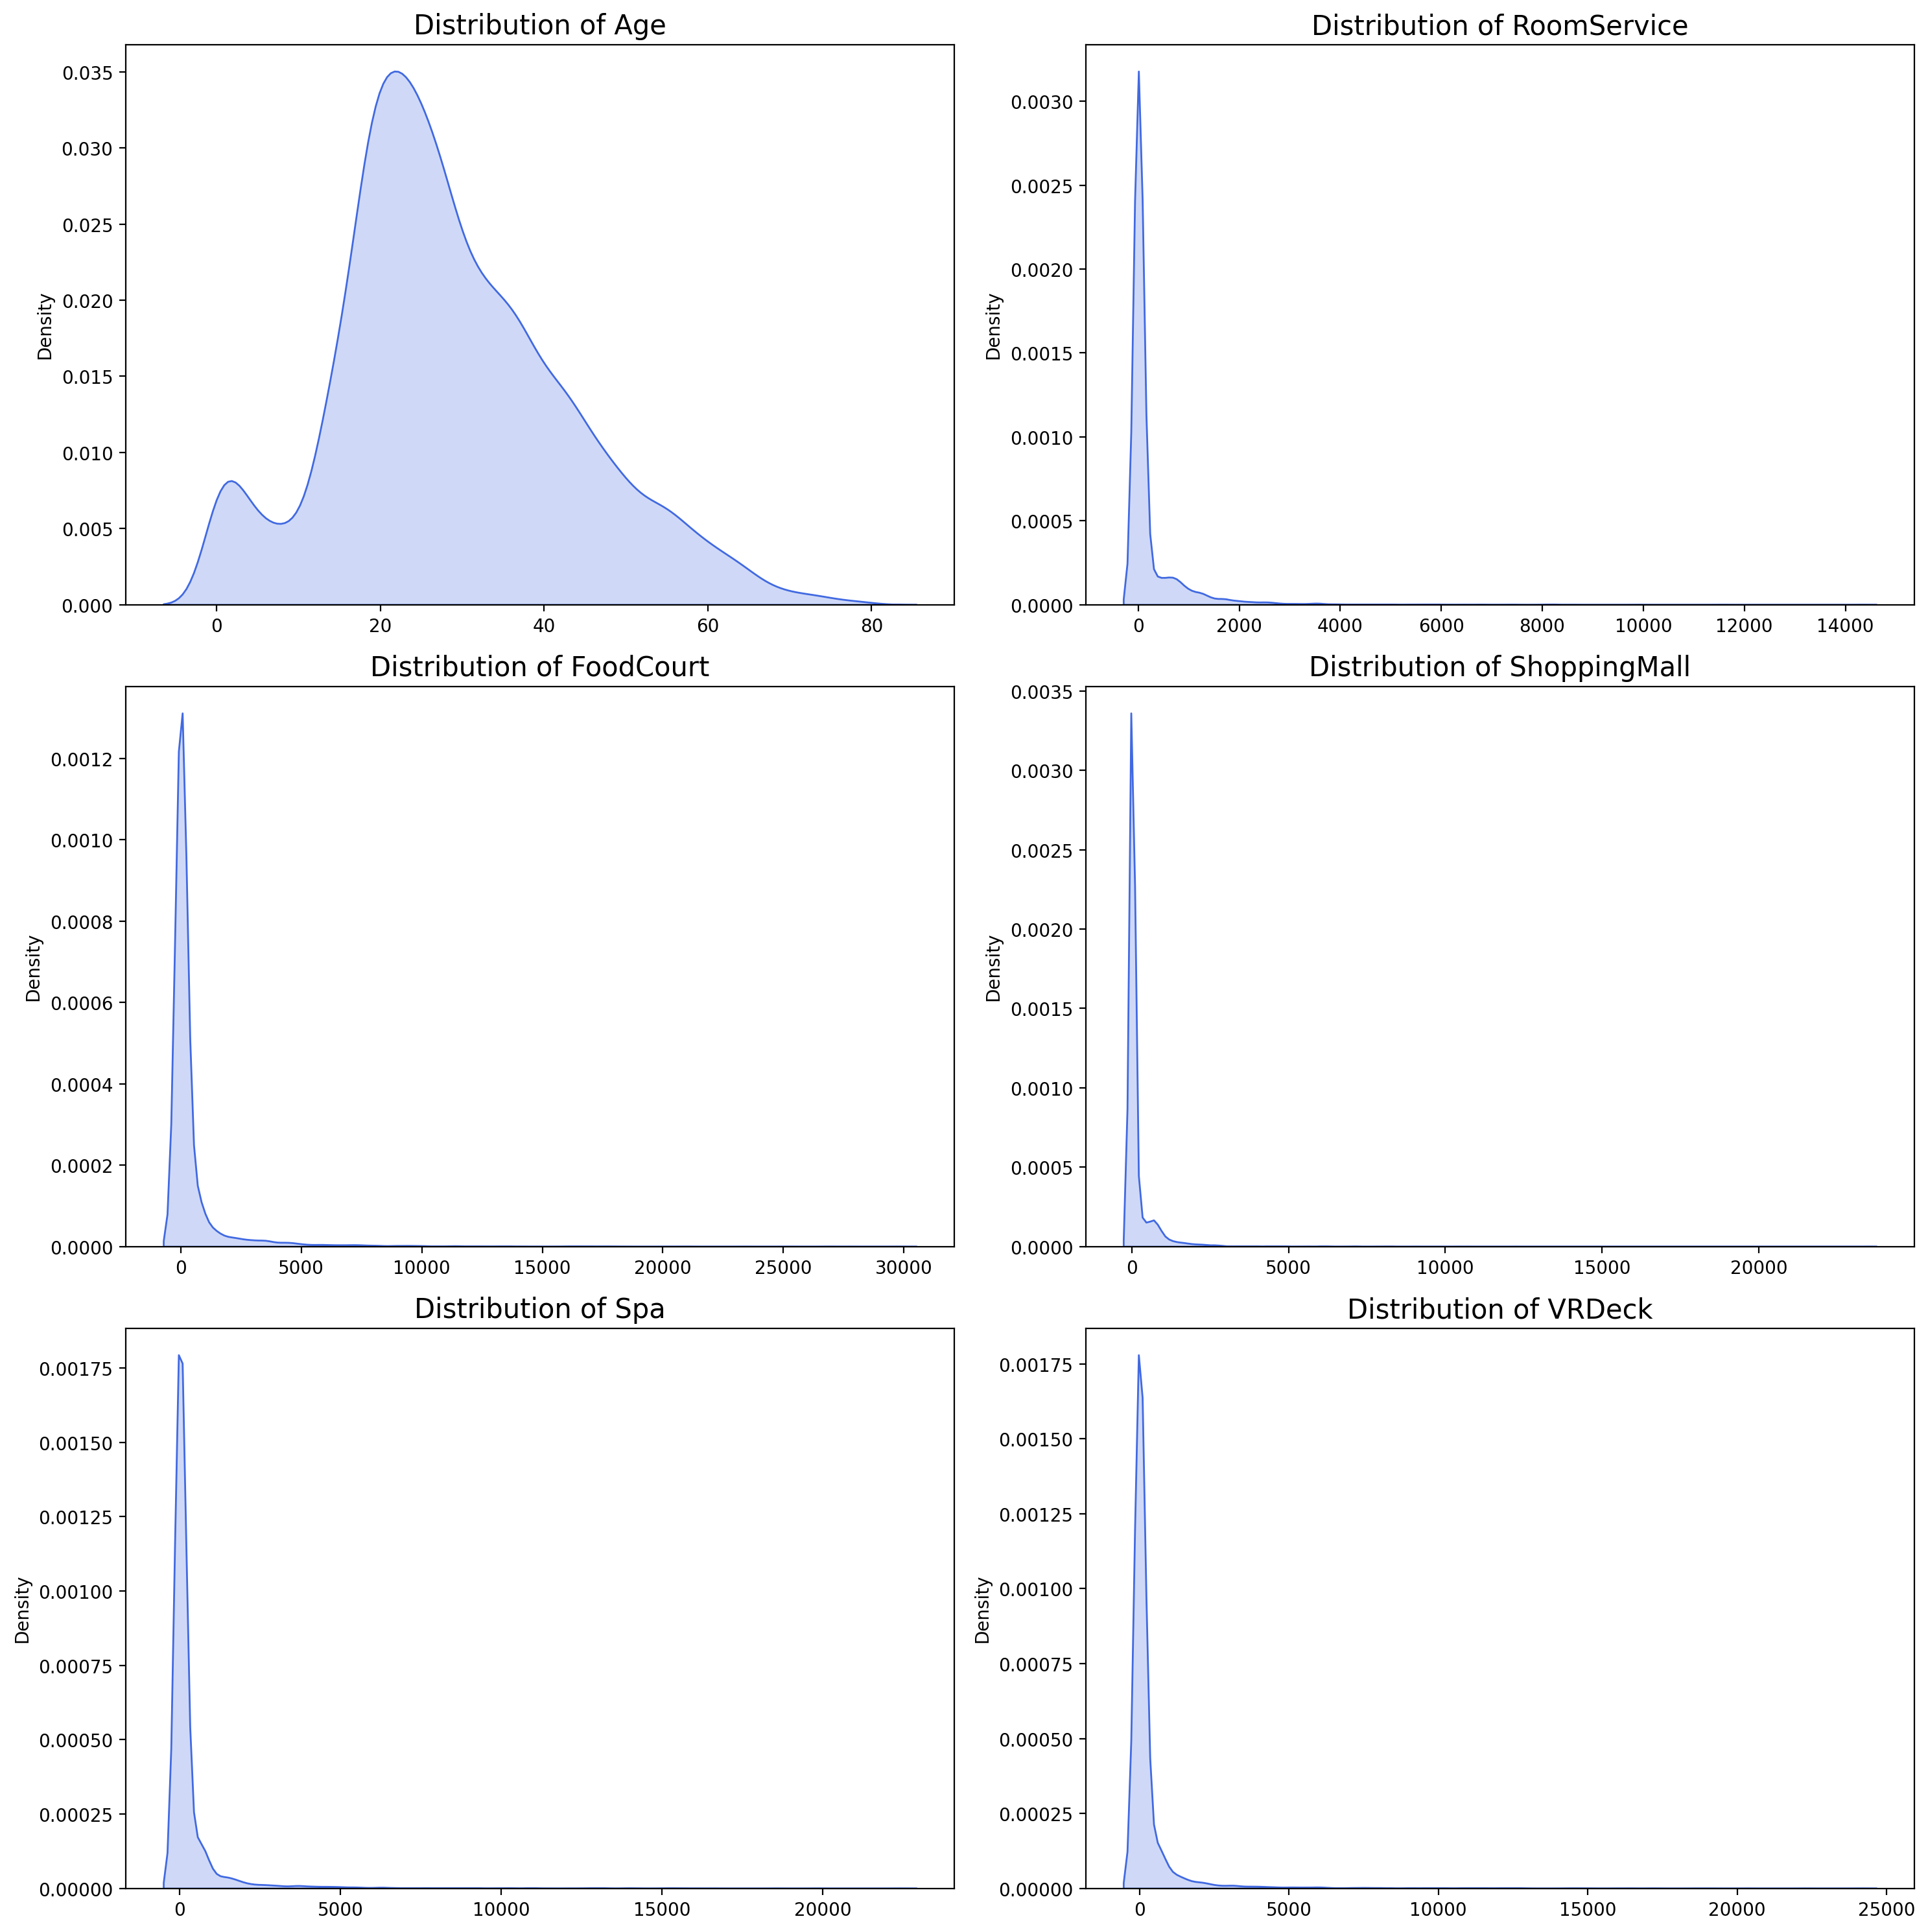

In [263]:
def plot_numeric_distributions(data):
    # 수치형 컬럼 추출
    numeric_cols = data.select_dtypes(include=['number']).columns
    n_cols = len(numeric_cols)
    
    # 컬럼 개수에 맞춰서 행(row) 개수 계산 (한 줄에 2개씩)
    n_rows = (n_cols + 1) // 2
    
    fig, ax = plt.subplots(n_rows, 2, figsize=(15, 5 * n_rows))
    ax = ax.flatten()
    
    for i, col in enumerate(numeric_cols):
        # 결측치를 제외하고 시각화
        sns.kdeplot(data=data[col].dropna(), ax=ax[i], fill=True, color='royalblue')
        ax[i].set_title(f'Distribution of {col}', fontsize=15)
        ax[i].set_xlabel('')
    
    # 남는 빈 칸(subplot) 안 보이게 지우기
    for j in range(i + 1, len(ax)):
        fig.delaxes(ax[j])
        
    plt.tight_layout()
    plt.show()

plot_numeric_distributions(data)

### Handling Missing data, 불필요한 데이타
PassengerId에서 힌트를 얻어서, 앞에 gggg_pp 형식인데 앞에 gggg를 뽑아내서 group를 만들었다..

#### Missing data
- HomePlanet, Destination, VIP, Age, Cabin도 그룹을 참조해서 결측치를 채웠습니다.
- 자출이 하나도 없으면 CryoSleep이 false
- CryoSleep이 false면 지출항목('RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck')을 0으로 채움

#### 불필요한 데이타
- Name
- PassengerId
- 임시로 만들었던 Group
- Cabin - Cabin_deck, Cabin_side, Cabin_num 으로 쪼개서 기존 Cabin이 필요없음

In [264]:
data['Group'] = data['PassengerId'].apply(lambda x: x.split('_')[0])
# 같은 그룹 내에서 CryoSleep 값이 다양하게(2개) 존재하는 그룹의 개수를 확인
group_sleep_variety = data.groupby('Group')['CryoSleep'].nunique()
mixed_groups = group_sleep_variety[group_sleep_variety > 1]
print(f"그룹 내에서 잠자는 사람과 깨어있는 사람이 섞여 있는 그룹 수: {len(mixed_groups)}")
data.drop('Group', axis=1, inplace=True)

그룹 내에서 잠자는 사람과 깨어있는 사람이 섞여 있는 그룹 수: 1230


In [265]:
data['Group'] = data['PassengerId'].apply(lambda x: x.split('_')[0])

# 같은 그룹
data['HomePlanet'] = data.groupby('Group')['HomePlanet'].ffill().bfill()
data['Destination'] = data.groupby('Group')['Destination'].ffill().bfill()
data['VIP'] = data.groupby('Group')['VIP'].ffill().bfill()

# 같은 그룹에서도 없으면 가장 많이 등장하는 값
data['HomePlanet'] = data['HomePlanet'].fillna(data['HomePlanet'].mode()[0])
data['Destination'] = data['Destination'].fillna(data['Destination'].mode()[0])
data['VIP'] = data['VIP'].fillna(data['VIP'].mode()[0])

expenses = ['RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']

# 먼저 지출이 있는 사람을 보고 CryoSleep 결측치를 False(깬 상태)로 채웁니다.
for col in expenses:
    data.loc[(data['CryoSleep'].isnull()) & (data[col] > 0), 'CryoSleep'] = False
# 그래도 남은 CryoSleep 결측치는 최빈값으로 채우기
data['CryoSleep'] = data['CryoSleep'].fillna(data['CryoSleep'].mode()[0])


# 이제 CryoSleep이 확정되었으니, 거꾸로 CryoSleep이 True(잠든 상태)인 승객의 지출 빈칸을 0으로 채웁니다.
for col in expenses:
    data.loc[(data['CryoSleep'] == True) & (data[col].isnull()), col] = 0
# 나머지 모든 지출 빈칸은 중앙값으로 채웁니다.
for col in expenses:
    data[col] = data[col].fillna(data[col].median())


data['Age'] = data.groupby('Group')['Age'].transform(lambda x: x.fillna(x.mean()))
data['Age'] = data['Age'].fillna(data['Age'].median())    

data['Cabin_deck'] = data['Cabin'].str.split('/').str[0]
data['Cabin_num'] = data['Cabin'].str.split('/').str[1]
data['Cabin_side'] = data['Cabin'].str.split('/').str[2]
data['Cabin_num'] = pd.to_numeric(data['Cabin_num'], errors='coerce')

data['Cabin_deck'] = data.groupby('Group')['Cabin_deck'].ffill().bfill()
data['Cabin_side'] = data.groupby('Group')['Cabin_side'].ffill().bfill()
data['Cabin_num'] = data.groupby('Group')['Cabin_num'].ffill().bfill()
# 일행이 없어 여전히 비어있는 칸은 최빈값과 중앙값으로 마무리
data['Cabin_deck'] = data['Cabin_deck'].fillna(data['Cabin_deck'].mode()[0])
data['Cabin_side'] = data['Cabin_side'].fillna(data['Cabin_side'].mode()[0])
data['Cabin_num'] = data['Cabin_num'].fillna(data['Cabin_num'].median())


test_id = data.iloc[train_len:, :]['PassengerId']

data = data.drop(['Name','Cabin', 'Group','PassengerId'], axis=1)

data.isnull().sum()

HomePlanet      0
CryoSleep       0
Destination     0
Age             0
VIP             0
RoomService     0
FoodCourt       0
ShoppingMall    0
Spa             0
VRDeck          0
Cabin_deck      0
Cabin_num       0
Cabin_side      0
dtype: int64

### Data 변환
- 모델은 데이타를 숫자로만 받아들여서 Error가 발생하고,그리고 범주형으로 만드는게  유리...연속된 숫자보다...
- 'RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck'가 다들 한쪽으로 몰려있음....
- 그래서 log를 취했더니 오히려  아주 미세하게 정확도가 더 떨어졌음...0.02 정도 
- 결정 트리(Tree) 기반 모델은 로그에 무감각다고 하다고함..

<class 'pandas.DataFrame'>
Index: 12970 entries, 0 to 4276
Data columns (total 21 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Age                        12970 non-null  float64
 1   RoomService                12970 non-null  float64
 2   FoodCourt                  12970 non-null  float64
 3   ShoppingMall               12970 non-null  float64
 4   Spa                        12970 non-null  float64
 5   VRDeck                     12970 non-null  float64
 6   Cabin_num                  12970 non-null  float64
 7   HomePlanet_Europa          12970 non-null  bool   
 8   HomePlanet_Mars            12970 non-null  bool   
 9   CryoSleep_True             12970 non-null  bool   
 10  Destination_PSO J318.5-22  12970 non-null  bool   
 11  Destination_TRAPPIST-1e    12970 non-null  bool   
 12  VIP_True                   12970 non-null  bool   
 13  Cabin_deck_B               12970 non-null  bool   
 14  Cabin_d

None

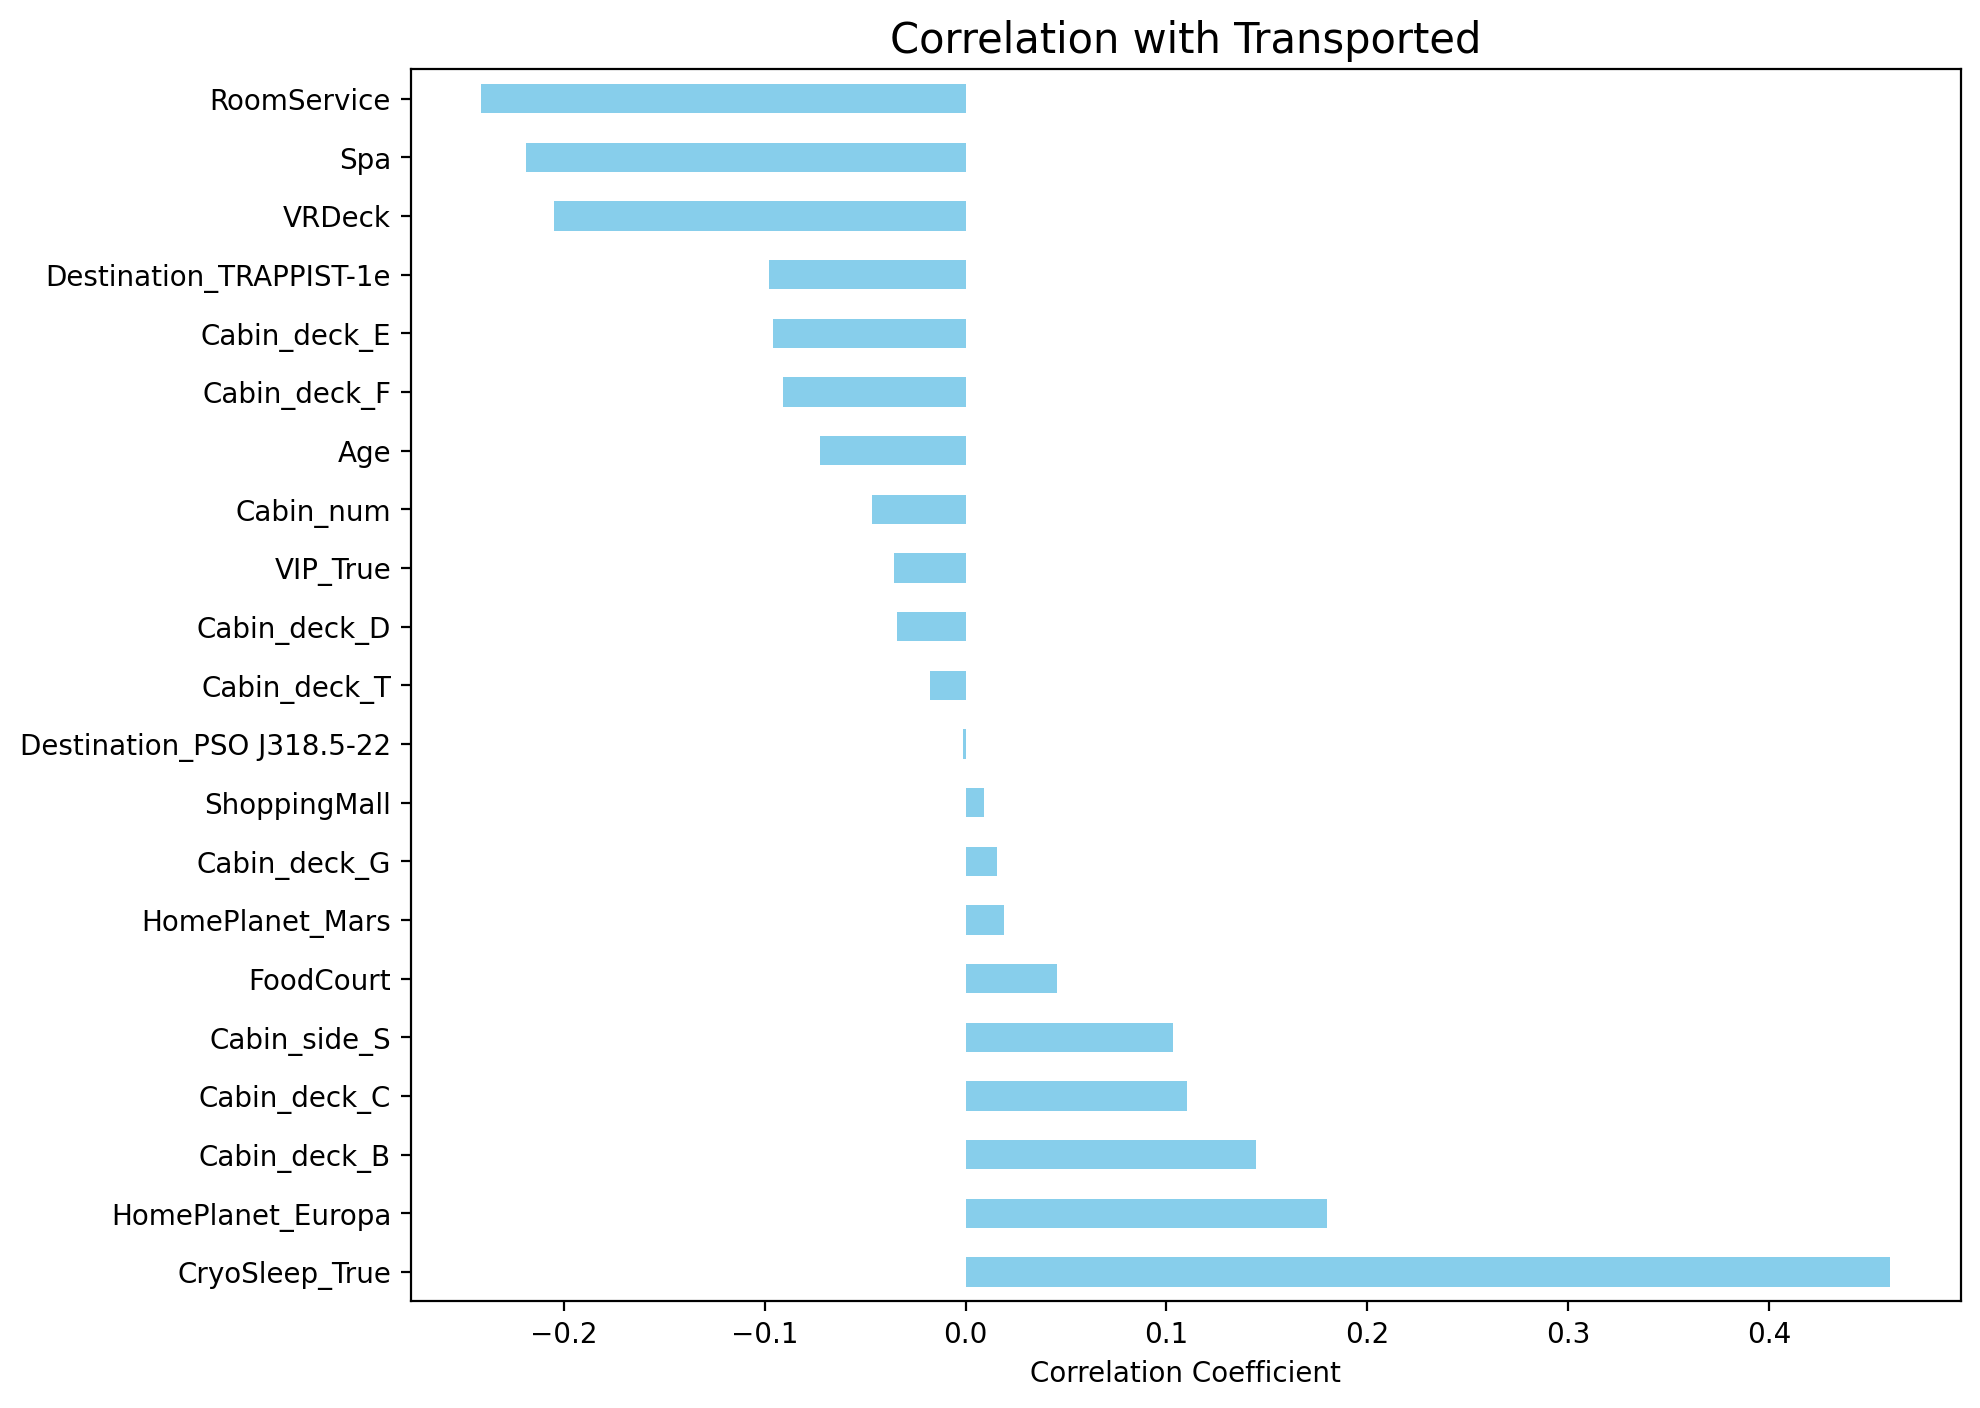

Target                       1.000000
CryoSleep_True               0.460132
HomePlanet_Europa            0.179815
Cabin_deck_B                 0.144772
Cabin_deck_C                 0.110094
Cabin_side_S                 0.103359
FoodCourt                    0.045583
HomePlanet_Mars              0.018938
Cabin_deck_G                 0.015833
ShoppingMall                 0.009391
Destination_PSO J318.5-22   -0.001152
Cabin_deck_T                -0.017712
Cabin_deck_D                -0.034223
VIP_True                    -0.035560
Cabin_num                   -0.046512
Age                         -0.072386
Cabin_deck_F                -0.091007
Cabin_deck_E                -0.096043
Destination_TRAPPIST-1e     -0.097659
VRDeck                      -0.204874
Spa                         -0.218545
RoomService                 -0.241124
Name: Target, dtype: float64


In [266]:
data = pd.get_dummies(data, drop_first=True)
display(data.info())

# 1. 학습 데이터와 정답을 잠시 합칩니다.
train_df = x.copy()
train_df['Target'] = y.astype(int).values
# 2. 정답(Target)과의 상관계수만 추출해서 정렬합니다.
correlations = train_df.corr()['Target'].sort_values(ascending=False)
# 3. 시각화
plt.figure(figsize=(10, 8))
correlations.drop('Target').plot(kind='barh', color='skyblue')
plt.title('Correlation with Transported', fontsize=15)
plt.xlabel('Correlation Coefficient')
plt.show()
print(correlations)

#### 변수설명 
- x: train feature
- sub: test feature
- y: 정답지(Transported)
 

In [ ]:

sub = data.iloc[train_len:, :]
x = data.iloc[:train_len, :]

print(x.shape)
print(sub.shape)

(8693, 21)
(4277, 21)


#### Model 설정
- Classification 문제이므로 GradientBoostingClassifier, XGBoost, LightGBM을 사용합니다.
- 단독 모델을 사용할때보다 앙상블 조합이 더 좋은 성능을 보여주므로, 앙상블 모델을 사용합니다.
- 처음에 3개의 모델을 사용했었다..XGBoost가 평균을 깎아 먹어서 제거...

In [268]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold, cross_val_score
import xgboost as xgb
import lightgbm as lgb


models = [
    # {
    #      'name': 'XGBoost', 
    #      'model': xgb.XGBClassifier(n_estimators=100, random_state=42)
    # },
    {
        'name': 'LightGBM', 
        'model': lgb.LGBMClassifier(n_estimators=100, random_state=42)
    },
    {
        'name': 'GradientBoosting', 
        'model': GradientBoostingClassifier(n_estimators=100, random_state=42)
    }
]


In [269]:
def my_GridSearch(model, train, y, param_grid, verbose=2, n_jobs=5):
    # 1. GridSearchCV 모델 초기화 (정확도 기준)
    grid_model = GridSearchCV(model, param_grid=param_grid, \
                              scoring='accuracy', \
                              cv=5, verbose=verbose, n_jobs=n_jobs)
    
    # 2. 모델 학습
    grid_model.fit(train, y)

    # 3. 결과값 저장
    params = grid_model.cv_results_['params']
    score = grid_model.cv_results_['mean_test_score']
    
    # 4. 데이터프레임 생성 및 정렬
    results = pd.DataFrame(params)
    results['score'] = score
    results = results.sort_values('score', ascending=False)

    return results


### Parameter 조합
- 파라메터를 변경해서 나온결과는 오히려 더 좋지 않았음.
- 그래서 아래코드는 실행을 안시켰음...

In [270]:
# 1. 각 모델별로 테스트하고 싶은 파라미터들 정의
param_grids = {
    'XGBoost': {
        'n_estimators': [50, 100, 300],
        'max_depth': [3, 4, 5],
        'learning_rate': [0.05, 0.1, 0.3]
    },
    'LightGBM': {
        'n_estimators': [50, 100, 300],
        'max_depth': [3, 4, 5],
        'learning_rate': [0.05, 0.1, 0.3]
    },
    'GradientBoosting': {
        'n_estimators': [50, 100, 300],
        'max_depth': [3, 4, 5],
        'learning_rate': [0.05, 0.1, 0.3]
    }
}

# 2. 반복문을 통해 3개 모델 모두 테스트
grid_results = {}

for m in models:
    model_name = m['name']
    print(f"[{model_name}] 그리드 서치 시작...")
    
    # 모델과 해당 모델의 파라미터 그리드 가져오기
    model = m['model']
    param_grid = param_grids[model_name]
    
    # 위에서 정의한 my_GridSearch 함수 호출
    result = my_GridSearch(model, x, y.astype(int), param_grid, verbose=1)
    
    # 결과 저장 및 출력
    grid_results[model_name] = result
    print(f"[{model_name}] 최적 스코어: {result.iloc[0]['score']:.4f}")
    display(result.head(3)) # 상위 3개 조합 출력
    print("-" * 50)

grid_results    

[LightGBM] 그리드 서치 시작...
Fitting 5 folds for each of 27 candidates, totalling 135 fits
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 3503, number of negative: 3452
[LightGBM] [Info] Number of positive: 3502, number of negative: 3452
[LightGBM] [Info] Number of positive: 3502, number of negative: 3452
[LightGBM] [Info] Number of positive: 3502, number of negative: 3452[LightGBM] [Info] Number of positive: 3503, number of negative: 3452

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002480 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if 

,learning_rate,max_depth,n_estimators,score
10,0.10,3,100,0.792712
9,0.10,3,50,0.791446
7,0.05,5,100,0.788226


--------------------------------------------------
[GradientBoosting] 그리드 서치 시작...
Fitting 5 folds for each of 27 candidates, totalling 135 fits
[GradientBoosting] 최적 스코어: 0.7897


,learning_rate,max_depth,n_estimators,score
9,0.10,3,50,0.789720
1,0.05,3,100,0.789030
10,0.10,3,100,0.787995


--------------------------------------------------


{'LightGBM':     learning_rate  max_depth  n_estimators     score
 10           0.10          3           100  0.792712
 9            0.10          3            50  0.791446
 7            0.05          5           100  0.788226
 2            0.05          3           300  0.787879
 1            0.05          3           100  0.787764
 15           0.10          5            50  0.787421
 4            0.05          4           100  0.786271
 18           0.30          3            50  0.785465
 13           0.10          4           100  0.785350
 12           0.10          4            50  0.785235
 6            0.05          5            50  0.783050
 5            0.05          4           300  0.780748
 16           0.10          5           100  0.780519
 0            0.05          3            50  0.779482
 3            0.05          4            50  0.778909
 21           0.30          4            50  0.778793
 11           0.10          3           300  0.776261
 8            0.

### 평가지표

#### Accuracy (정확도) : "정답을 몇 개 맞혔나?"
- 의미: 전체 승객 중 전송 여부(True/False)를 정확하게 맞춘 비율입니다.
- 직관적 이해: 시험 점수와 똑같습니다. "100명 중 79명을 맞혔으면 79점"입니다.
- 방향: 높을수록 좋습니다.
- 중요성: 캐글 리더보드 순위를 결정하는 기준입니다.
- cross_val_score와 kfold는 80:20 나누기를 5번 반복하는 최고급 방식입니다.


In [271]:
def get_scores(models, x, y):
    df = {}
    y_int = y.astype(int)
    kfold = KFold(n_splits=5, shuffle=True, random_state=42)
    
    for m in models:
        model_name = m['name']
        model = m['model']
        
        # Accuracy(정확도) 계산
        acc_score = cross_val_score(model, x, y_int, scoring="accuracy", cv=kfold)
       
        df[model_name] = {
            'Accuracy': np.mean(acc_score),
        }
        
    # Accuracy가 높은 순서대로 출력
    score_df = pd.DataFrame(df).T.sort_values('Accuracy', ascending=False)
    return score_df

### 값 history
| Model | Accuracy |
| :--- | :--- |
| LightGBM | 0.806971 |
| GradientBoosting | 0.802601 |
| XGBoost | 0.800068 |

In [272]:
display(get_scores(models, x, y.astype(int)))

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 3500, number of negative: 3454
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000551 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1635
[LightGBM] [Info] Number of data points in the train set: 6954, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503307 -> initscore=0.013230
[LightGBM] [Info] Start training from score 0.013230
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 3492, number of negative: 3462
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000678 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise

,Accuracy
LightGBM,0.805246
GradientBoosting,0.801450


In [273]:
def AveragingBlending(models, x, y, sub_x):
    # 각 모델 학습
    for m in models :
        m['model'].fit(x.values, y)

    # 각 모델의 '확률'을 추출 (Soft Voting)
    # [:, 1]은 '전송되었을 확률(True/1)'만 가져오는 것입니다.
    predictions = np.column_stack([
        m['model'].predict_proba(sub_x.values)[:, 1] for m in models
    ])
    
    # 확률들의 평균 계산
    mean_pred = np.mean(predictions, axis=1)
    
    # 평균 확률이 0.5보다 크면 1(True), 아니면 0(False)로 반환
    return (mean_pred > 0.5).astype(int)

### Blending 한 모델의 정확도
accuracy_score를 이용
- 초기값 앙상블 모델의 예상 정확도: 0.7993
- d.get_dummies(data, drop_first=True)를 사용하여  drop_first=True를 사용하여 피쳐를줄였다니 :0.8033

[LightGBM] [Info] Number of positive: 3500, number of negative: 3454
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000940 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1635
[LightGBM] [Info] Number of data points in the train set: 6954, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503307 -> initscore=0.013230
[LightGBM] [Info] Start training from score 0.013230
앙상블 모델의 예상 정확도: 0.8010
              precision    recall  f1-score   support

           0       0.82      0.76      0.79       861
           1       0.78      0.84      0.81       878

    accuracy                           0.80      1739
   macro avg       0.80      0.80      0.80      1739
weighted avg       0.80      0.80      0.80      1739



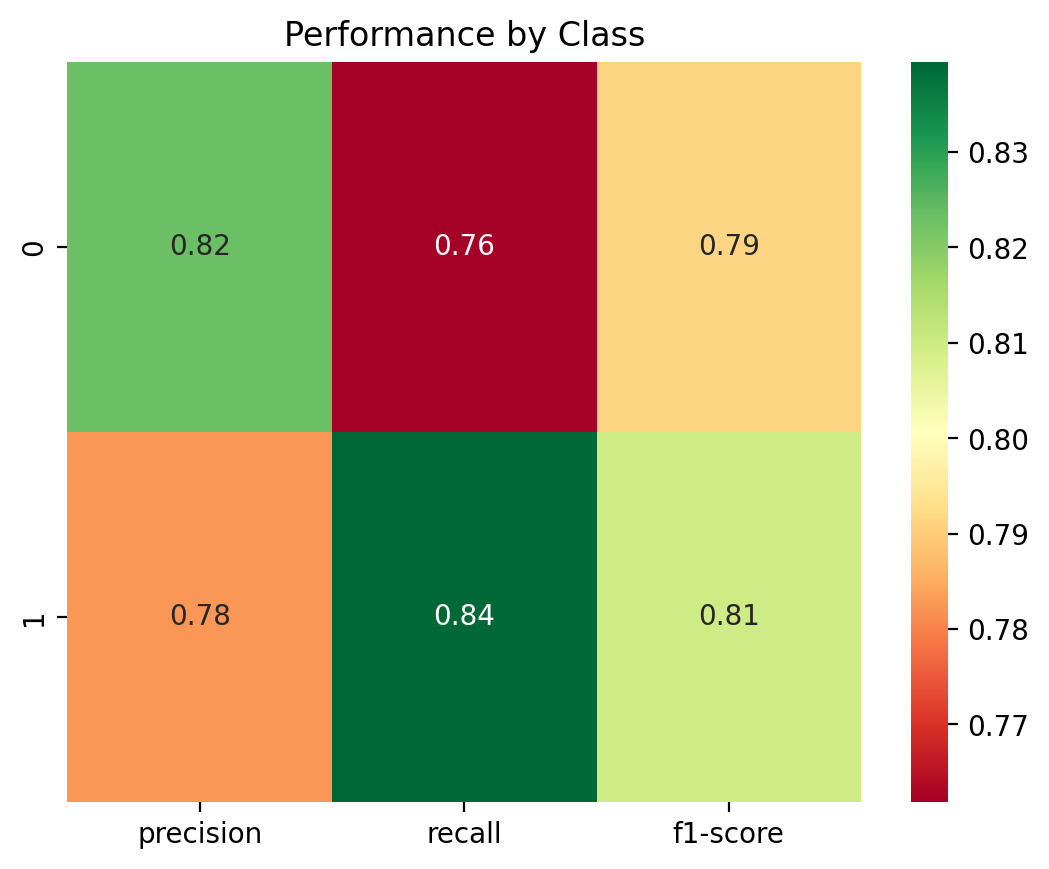

In [ ]:
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(x, y, test_size=0.2, random_state=42)



val_predictions = AveragingBlending(models, X_train, y_train, X_val)

score = accuracy_score(y_val.astype(int), val_predictions)
print(f"앙상블 모델의 예상 정확도: {score:.4f}")

from sklearn.metrics import classification_report
print(classification_report(y_val.astype(int), val_predictions))


### 최종 결과를 csv파일로 만들기..
- submission.csv로 저장한다.

In [277]:

# test_id와 합쳐서 데이터프레임 만들기
submission = pd.DataFrame({
    'PassengerId': test_id,
    'Transported':  AveragingBlending(models, x, y, sub).astype(bool)
})

# CSV 파일로 저장
submission.to_csv(join(data_dir, 'submission.csv'), index=False)

print("성공적으로 submission.csv 파일이 생성되었습니다!")
display(submission.head()) # 잘 만들어졌는지 눈으로 확인

[LightGBM] [Info] Number of positive: 4378, number of negative: 4315
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001062 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1636
[LightGBM] [Info] Number of data points in the train set: 8693, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503624 -> initscore=0.014495
[LightGBM] [Info] Start training from score 0.014495
성공적으로 submission.csv 파일이 생성되었습니다!


,PassengerId,Transported
0,0013_01,True
1,0018_01,False
2,0019_01,True
3,0021_01,True
4,0023_01,True


![result](result.png)

## 회고

### 이번 프로젝트를 하면서 느낀점, 배운점 
지금까지 배운것을 총정리하면서, 하나의 프로젝트에 적용해 볼수 있어서 좋았습니다.

### 이번 프로젝트에서 잘 했다고 생각이 드는 점.
- 데이타 분석시 여러가지 방법을 시도해 보았습니다.
- 데이타와의 상관관계등 의미를 분석해 보았습니다.
- 간단한 것이지만 어떻게 프로젝트를 진행하는지, 전체적인 프로세스를 생각해 보았고, 익숙해졌습니다.

### 이번 프로젝트에서 느낀 문제점.
- 아직 판다스 라이브러니와 머신러닝 라이브러리에 익숙하지 않았습니다.
- 라이브러리 관련해서 정확하게 이해하지 못했습니다.
- 문법적인 측면과 검색적인 부분에서 AI의 도움을 받았습니다.
- 파마레터를 조정하는 부분에서 몰라서 그런지 효과가 없었고, 오히려 3개의 모델중 떨어지는 하나의 모델을 빼니 오히려 정확도가 높아졌습니다.
- 데이타의 쏠림 현상이 심해서 log 스케일 사용을 했었는데, 오히려 정확도가 떨어졌습니다. 결정 트리(Decision Tree)' 기반 모델에는 크게 의미가 없다고 합니다. 아직 잘 모르겠습니다. 이부분에 대해서...
- Confusion Matrix 활용을 못했다.

### 다음에는 이렇게 해야겠다 생각한 점.
- 여러개의 모델을 조합해서 쓰는 앙상블에 대해서 리서치를 해야겠습니다.